### PA3: Structrue from Motion
#### In this assignment, you will be implementing Tomasi-Kanade	Factorization algorithm	for Rigid Structure from Motion (see Lecture 23).

### Task 1
#### Since we do not want to introduce the complexity of extracting feature points from images and tracking them over multiple frames, here we will generate W matrix using syntheic data i.e. by projecting a 3D model on 2D image plane.

#### Load the data file and generate a 2D image dataset	by generating an orthographic camera with optical axis paralle to the XY plane, which rotates around the teapot	in 10° increments and always looks towards the center of the object

#### Note: Code for loading the point cloud and visualizing it has been given to you. Further build on it and take images of the teapot and visualize them

In [122]:
from scipy.io import loadmat
x = loadmat('teapot.mat')

In [267]:
a = []
b = []
c = []
for points in x['verts']:
    a.append(points[0])
    b.append(points[1])
    c.append(points[2])

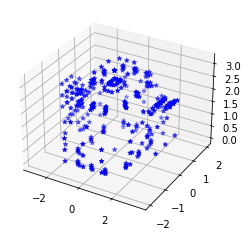

In [124]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a,b,c, c='b', marker='*')

In [125]:
### Your implementation comes here
import numpy as np
import math

intrinsic = np.array([[1, 0, 0],[0, 1, 0]])

def rotation_matrix_y(angle):
    rot_angle=math.radians(angle)
    R = np.array([[math.cos(rot_angle),0,math.sin(rot_angle)],[0,1,0],[-math.sin(rot_angle),0,math.cos(rot_angle)]])
    return R

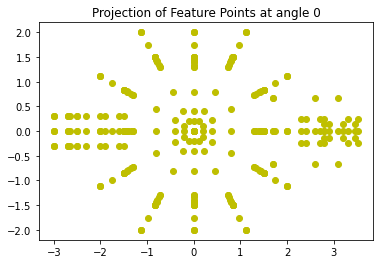

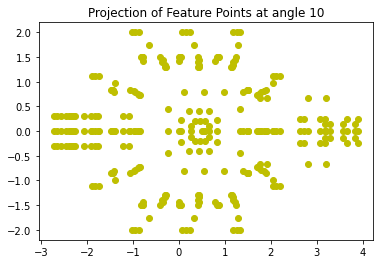

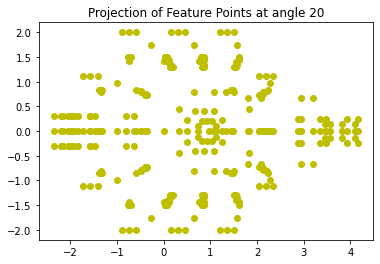

In [311]:
### Your implementation comes here
### Hint: new2Dpts = K[R|T]*3DPoints
### Useful functions: np.dot, np.vstack

thetas = np.arange(0,30,10)
W = []
R = []
for theta in thetas:
    X = intrinsic @ rotation_matrix_y(theta)
    W.append(X @ x['verts'].T)
    
W = np.vstack(W)
W.shape

plt.figure()
for i in range(0,W.shape[0],2):
    plt.scatter(W[i],W[i+1],color='y')
    plt.title(f"Projection of Feature Points at angle {thetas[ int(i/2) ]}")
    plt.show()

### Task 2
#### Use the data generated in previous task to generate a W matrix, and use that as input in Tomasi Kanade Factorization method to compute the 3D structure

In [312]:
### Your implementation for Tomasi Kanade Factorization method comes here
### Useful functions: np.dot, np.linalg.svd, np.linalg.pinv, np.linalg.cholesky

u, s, v = np.linalg.svd(W)

Rhat = u[:,:3]
Shat = v[:3,:]
Sc = s[:3, ]

scaling_matrix  = np.zeros((3,3))
np.fill_diagonal(scaling_matrix, scaling_matrix.diagonal() + Sc)

Shat = (Shat.T @ scaling_matrix).T


A = []
B = []

for i in range(0,Rhat.shape[0],2):
    r = Rhat[i:i+2,:]
    r1 = r[0][0]
    r2 = r[0][1]
    r3 = r[0][2]
    r4 = r[1][0]
    r5 = r[1][1]
    r6 = r[1][2]
    A.append(np.array([
        [r1*r1, 2*r1*r2, 2*r1*r3, r2*r2, 2*r2*r3, r3*r3],
        [r1*r4, r2*r4 + r1*r5, r3*r4 + r1*r6, r2*r5, r3*r5 + r2*r6, r3*r6],
        [r4*r4, 2*r4*r5, 2*r4*r6, r5*r5, 2*r5*r6, r6*r6]] )
        )
    B.append(np.array([1.,0.,1.]))

A = np.vstack(A)
B = np.array(B).reshape(-1,1)
sol = np.linalg.pinv(A) @ B

QQt= np.zeros((3,3))
QQt[0][0] = sol[0]
QQt[0][1] = sol[1]
QQt[0][2] = sol[2]
QQt[1][0] = sol[1]
QQt[1][1] = sol[3]
QQt[1][2] = sol[4]
QQt[2][0] = sol[2]
QQt[2][1] = sol[4]
QQt[2][2] = sol[5]

Q = np.linalg.cholesky(QQt)
S = np.linalg.pinv(Q) @ Shat

a1= S[0]
b1 = S[1]
c1 = S[2]

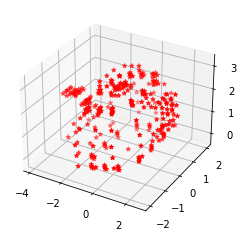

In [313]:
## Plot the reconstructed mode

# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the reconstructed 3D points are 
# in variables a1, b1 and c1 respectively, the reconstructed model can be plotted as:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a1,b1,c1, c='r', marker='*')

In [314]:
## Evaluate your reconstruction
# In the base code above we copied the x, y and z component of the 3D points
# in teapot 3D model that we loaded from teapot.mat in variables a, b, and c respectively
# Assuming the x, y and z component of the 3D points that you have reconstructed are 
# in variables a1, b1 and c1 respectively, the error in reconstruction can be calcualted as:

err = 0.0
j = 0
for i in range(len(a1)):
  err = err + math.sqrt( ((a1[i]-a[i])*(a1[i]-a[i])) + ((b1[i]-b[i])*(b1[i]-b[i])) + ((c1[i]-c[i])*(c1[i]-c[i])) )
  j=j+1
  
print ("Mean Euclidean Error : ",(err/j))

Mean Euclidean Error :  2.794390231574598
